## Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import recall_score, precision_score, classification_report

# setting yang diperlukan
%matplotlib inline
pd.set_option('display.max_columns', None) # setting pandas agar menampilkan semua kolom jika kolom terlalu banyak
plt.style.use('dark_background') # dark mode for visualization
sns.set_palette('bright') # global color palette

## Load dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/WA_FnUseC_TelcoCustomerChurn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# melihat sekilas keseluruhan meta data, jumlah baris, dan jumlah missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


total baris keseluruhan berjumlah 7043, sekilas tidak ada missing values, tipe kolom didominasi object (string) sisanya numerik.  
Namun ada yang ganjal, TotalCharges lebih tepat numerik, ini bisa jadi mengindikasikan adanya nilai invalid/missing value dalam bentuk string.
<br><br>
**DESKRIPSI DATA**  
* customerID : ID pelanggan, digunakan hanya sebagai unique identifier tiap pelanggan.
* gender : jenis kelamin pelanggan.
* SeniorCitizen : 1 jika pelanggan adalah penduduk senior, 0 jika tidak.
* Partner : menyatakan apakah pelanggan punya pasangan.
* Dependents : menyatakan apakah pelanggan punya tanggungan.
* tenure : berapa lama pelanggan berlangganan (dalam bulan).
* PhoneService : menyatakan apakah pelanggan berlangganan layanan telefon.
* MultipleLines : menyatakan apakah pelanggan yang berlangganan layanan telefon menggunakan sistem multi saluran.
* InternetService: menyatakan Jenis layanan internet (DSL, Fiber optic atau tidak menggunakan layanan ini) yang pelanggan guanakan.
* OnlineSecurity : menyatakan apakah pelanggan memiliki layanan keamanan online.
* OnlineBackup : menyatakan apakah pelanggan memiliki layanan pencadangan online.
* DeviceProtection : menyatakan apakah pelanggan memiliki layanan proteksi device.
* TechSupport : menyatakan apakah pelanggan punya dukungan teknis.
* StreamingTV : menyatakan apakah pelanggan memiliki layanan streaming TV.
* StreamingMovies : menyatakan apakah pelanggan memiliki layanan streaming film.
* Contract: jenis kontrak (Month-to-month, One year, Two year).
* PaperlessBilling: apakah pelanggan menggunakan tagihan tanpa kertas.
* PaymentMethod: metode pembayaran (Electronic check, Mailed check, Bank transfer, atau Credit card).
* MonthlyCharges: biaya bulanan yang dibayar pelanggan.
* TotalCharges: total biaya yang sudah dibayar pelanggan selama berlangganan.
* Churn: target variabel yang menunjukkan apakah pelanggan churn (Yes/No).



## Split Dataset

In [5]:
# pisahkan fitur dan target
X = df.drop(['Churn'], axis = 1)
y = df['Churn']

# split data train dan tes dengan perbandingan 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((5634, 20), (1409, 20))

In [6]:
X_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2142,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8
1623,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45
6074,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45
1362,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,


## Train

### EDA

#### Checking Duplicates

In [7]:
# menggabungkan prediktor dan target
train = pd.concat([X_train, y_train], axis = 1)

# cek duplikat, hasilnya tidak ditemukan
print(train.duplicated().sum())
print(train.duplicated(subset='customerID').sum()) # per ID

0
0


#### Checking Missing Values

In [8]:
# kolom TotalCharges bertipe objek padahal seharusnya float, ini karena ada baris yang TotalCharges-nya non numerik
# cek nilai invalid ' ' di kolom TotalCharges
train.loc[df['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [9]:
# kita bisa melihat pada semua baris dengan nilai 'kosong' di TotalCharges, tenurenya bernilai 0, sehingga dapat diduga bahwa mereka pelanggan baru
# dapat dilihat dengan mengambil semua baris yang tenure-nya 0, kode di bawah menghasilkan output yang sama dengan kode di atas
# sehigga dugaan tersebut dapat dikonfirmasi
train.loc[df['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [10]:
# selanjutnya, kita ubah nilai TotalCharges yang kosong menjadi 0 dan ubah tipe kolom TotalCharges untuk eksplorasi data
train.loc[train['TotalCharges'] == ' ', 'TotalCharges'] = 0
train['TotalCharges'] = train['TotalCharges'].astype(float)

# mengubah SeniorCitizen menjadi kategorik untuk pengecekan missing value
train['SeniorCitizen'] = train['SeniorCitizen'].astype('bool')
# mengubah targret menjadi boolean untuk analisis korelasi
train['Churn'] = train['Churn'] == 'Yes'

In [11]:
# sudah tidak ada duplikat, selanjutnya ubah tipe kolom
# kolom yang bertipe kategorik
category_columns = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'Churn'
]

# cek nilai unik dari setiap kolom kategorik
for column in category_columns:
    unique_values = train[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'gender': ['Female' 'Male']
Unique values in column 'SeniorCitizen': [False  True]
Unique values in column 'Partner': ['No' 'Yes']
Unique values in column 'Dependents': ['Yes' 'No']
Unique values in column 'PhoneService': ['Yes' 'No']
Unique values in column 'MultipleLines': ['No' 'Yes' 'No phone service']
Unique values in column 'InternetService': ['DSL' 'Fiber optic' 'No']
Unique values in column 'OnlineSecurity': ['Yes' 'No' 'No internet service']
Unique values in column 'OnlineBackup': ['No' 'Yes' 'No internet service']
Unique values in column 'DeviceProtection': ['Yes' 'No' 'No internet service']
Unique values in column 'TechSupport': ['No' 'Yes' 'No internet service']
Unique values in column 'StreamingTV': ['No' 'Yes' 'No internet service']
Unique values in column 'StreamingMovies': ['Yes' 'No' 'No internet service']
Unique values in column 'Contract': ['One year' 'Two year' 'Month-to-month']
Unique values in column 'PaperlessBilling': ['No' 'Yes']
Unique 

Kita bisa melihat bahwa semua kolom bertipe objek di data ini merupakan kolom kategorik dengan kardinalitas rendah. Beberapa hanya terdiri dari 2 kemungkinan nilai, sehingga cocok untuk label encoding atau one hot encoding. Selain itu tidak ditemukan missing values yang menyamar sebagai string.

#### Cek Statistika Deskriptif

In [12]:
# statistika deskriptif kolom numerik
train.describe()

,tenure,MonthlyCharges,TotalCharges
count,5634.000000,5634.000000,5634.000000
mean,32.373092,64.864253,2287.087948
std,24.424539,30.089324,2263.197899
min,0.000000,18.250000,0.000000
25%,9.000000,35.750000,406.275000
50%,29.000000,70.525000,1405.650000
75%,55.000000,89.937500,3806.612500
max,72.000000,118.600000,8684.800000


Ringkasan statistika deskriptif kolom numerik

1. Tenure (Lama Berlangganan dalam Bulan)
- **Rata-rata**: Pelanggan memiliki lama berlangganan rata-rata sekitar 32 bulan.
- **Standar deviasi**: 24,24, menunjukkan bahwa ada variasi yang cukup besar dalam lama berlangganan pelanggan.
- **Minimum**: 0 bulan (pelanggan baru).
- **Kuartil**:
  - **25%** dari pelanggan berlangganan kurang dari atau sama dengan 9 bulan.
  - **50%** dari pelanggan (median) berlangganan kurang dari atau sama dengan 29 bulan.
  - **75%** dari pelanggan berlangganan kurang dari atau sama dengan 55 bulan.
- **Maksimum**: Pelanggan terlama telah berlangganan selama 72 bulan (6 tahun).

Ini menunjukkan distribusi yang cukup tersebar, dengan sebagian pelanggan baru dan sebagian lainnya sudah lama berlangganan. Mean lebih besar dari median, menunjukkan distribusi condong miring ke kanan.

2. MonthlyCharges (Biaya Bulanan)
- **Rata-rata**: Pelanggan membayar sekitar \$64,86 per bulan.
- **Standar deviasi**: 30,09, menunjukkan variasi biaya bulanan yang cukup besar antar pelanggan.
- **Minimum**: Biaya bulanan terendah adalah \$18,25.
- **Kuartil**:
  - **25%** dari pelanggan membayar kurang dari atau sama dengan \$35,75.
  - **50%** dari pelanggan membayar kurang dari atau sama dengan \$70,53.
  - **75%** dari pelanggan membayar kurang dari atau sama dengan \$89,94.
- **Maksimum**: Biaya bulanan tertinggi adalah \$118,6.

Biaya bulanan yang bervariasi ini bisa jadi karena perbedaan paket atau layanan tambahan yang dipilih pelanggan. Mean lebih kecil dari median, menunjukkan distribusi condong miring ke kiri.

3. TotalCharges (Total Biaya)
- **Rata-rata**: Total biaya yang dibayarkan oleh pelanggan sekitar \$2287.
- **Standar deviasi**: 2263,2, menunjukkan variasi besar dalam total biaya antar pelanggan.
- **Minimum**: Biaya total terendah adalah \$18,80.
- **Kuartil**:
  - **25%** dari pelanggan membayar total kurang dari atau sama dengan \$406,28.
  - **50%** dari pelanggan membayar total kurang dari atau sama dengan \$1405,65.
  - **75%** dari pelanggan membayar total kurang dari atau sama dengan \$3806,61.
- **Maksimum**: Biaya total tertinggi yang dibayarkan oleh pelanggan adalah $8684,8.

Total biaya menunjukkan distribusi yang sangat lebar, mencerminkan lama berlangganan dan mungkin tambahan layanan yang diambil oleh pelanggan. Mean lebih besar dari median, menunjukkan distribusi condong miring ke kanan.

Ada beberapa pola menarik disini:  
- **Tenure** dan **TotalCharges** memiliki rentang yang luas, menunjukkan ada pelanggan yang baru berlangganan dan yang sudah lama berlangganan.
- **MonthlyCharges** menunjukkan bahwa mayoritas pelanggan memiliki biaya bulanan di sekitar nilai median, tetapi ada pelanggan dengan biaya yang sangat rendah atau tinggi, mungkin karena perbedaan paket layanan.
- Variasi yang tinggi dalam **TotalCharges** juga menunjukkan potensi perbedaan kebiasaan atau preferensi pelanggan dalam memilih paket dan layanan tambahan.

In [13]:
# statistika deskriptif kolom kategorik
train.describe(include=['object','bool']).T

,count,unique,top,freq
customerID,5634,5634,4223-BKEOR,1
gender,5634,2,Male,2887
SeniorCitizen,5634,2,False,4728
Partner,5634,2,No,2904
Dependents,5634,2,No,3951
PhoneService,5634,2,Yes,5082
MultipleLines,5634,3,No,2685
InternetService,5634,3,Fiber optic,2481
OnlineSecurity,5634,3,No,2810
OnlineBackup,5634,3,No,2448


Ringkasan statistika deskriptif

- `CustomerID`  
  Tidak terdapat duplikat pada ID pelanggan
- `gender`  
  Pelanggan Telco pria sedikit lebih banyak dari wanita, dengan frekuensi 2887.
- `SeniorCitizen`  
  Mayoritas pelanggan Telco bukan warga senior, dengan frekuensi 4728.
- `Partner`  
  Pelanggan Telco yang tidak memiliki pasangan sedikit lebih banyak dari yang memiliki pasangan, dengan frekuensi 2904.
- `Dependents`  
  Mayoritas pelanggan Telco tidak memiliki tanggungan, dengan frekuensi 3951.
- `PhoneService`  
  Mayoritas memiliki layanan telepon, dengan frekuensi 5082.
- `MultipleLines`  
  Mayoritas pelanggan Telco tidak memiliki banyak saluran, dengan frekuensi 2685.
- `InternetService`  
  Mayoritas pelanggan Telco berlangganan servis internet dan "Fiber optic" adalah jenis layanan paling banyak digunakan, dengan frekuensi 2481.
- `OnlineSecurity`  
  Mayoritas pelanggan Telco tidak memiliki keamanan online, dengan frekuensi 2810.
- `OnlineBackup`  
  Mayoritas pelanggan Telco tidak memiliki pencadangan online, dengan frekuensi 2448.
- `DeviceProtection`  
  Mayoritas pelanggan Telco tidak memiliki layanan proteksi device, dengan frekuensi 2489.
- `TechSupport`  
  Mayoritas pelanggan Telco tidak memiliki dukungan teknis, dengan frekuensi 2791.
- `StreamingTV`  
  Mayoritas pelanggan Telco tidak memiliki layanan streaming TV, dengan frekuensi 2239.
- `StreamingMovies`  
  Mayoritas pelanggan Telco tidak memiliki layanan streaming film, dengan frekuensi 2223.
- `Contract`  
  "Month-to-month" adalah kontrak yang paling umum, dengan frekuensi 3083.
- `PaperlessBilling`  
  Mayoritas pelanggan Telco menggunakan tagihan tanpa kertas, dengan frekuensi 3325.
- `PaymentMethod`  
  "Electronic check" adalah metode pembayaran paling umum, dengan frekuensi 1887.
- `Churn`  
  Mayoritas pelanggan Telco tetap bertahan (non-churn), dengan frekuensi 4138.

Ada beberapa pola menarik disini:
1. Mayoritas pelanggan berlangganan layanan internet, namun tidak menggunakan layanan tambahan seperti keamanan dan pencadangan online, streaming TV dan film, proteksi device, dan dukungan teknis
2. Jumlah pelanggan yang berhenti berlangganan pada data train adalah 5634-4138= 1496 (26,55%). meskipun presentasinya lebih kecil tapi untuk ukuran churn, ini termasuk tinggi dan Telco harus berusaha meminimalisasi churn rate ini.
3. Data ini cukup tidak imbang, mungkin perlu dilakukan imbalance handling.

#### Analisis Univariat

##### Atribut Numerik

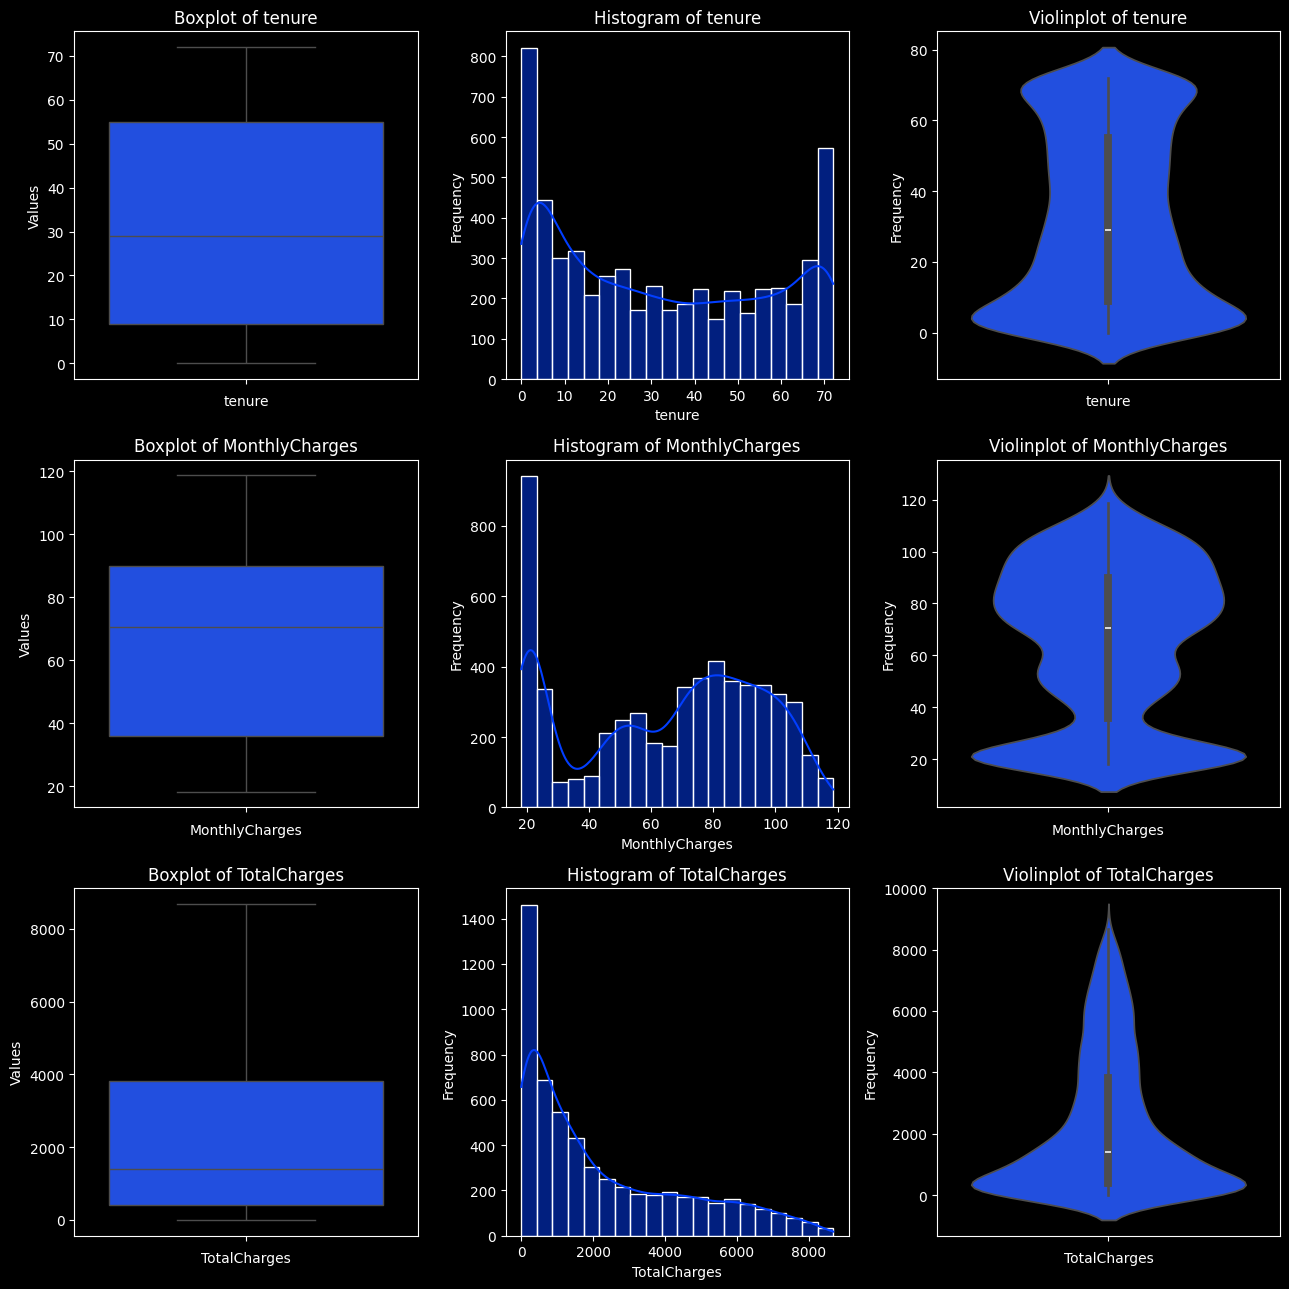

In [14]:
# membuat list kolom numerik
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Membuat subplot
fig, axes = plt.subplots(3, 3, figsize=(13, 13))

# Membuat boxplot untuk setiap kolom numerik
for i, column in enumerate(numeric_columns):
    sns.boxplot(train[column], ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Values')

# Membuat histogram untuk setiap kolom numerik
for i, column in enumerate(numeric_columns):
    sns.histplot(train[column], kde=True, ax=axes[i, 1], bins=20)
    axes[i, 1].set_title(f'Histogram of {column}')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Frequency')

# Membuat violinplot untuk setiap kolom numerik
for i, column in enumerate(numeric_columns):
    sns.violinplot(train[column], ax=axes[i, 2])
    axes[i, 2].set_title(f'Violinplot of {column}')
    axes[i, 2].set_xlabel(column)
    axes[i, 2].set_ylabel('Frequency')

# Menampilkan plot
plt.tight_layout()
plt.show()

Interpretasi Boxplot Kolom Numerik:

1. **Tenure**:  
   Tidak ada outlier yang terdeteksi. Distribusinya bimodal dengan puncak pada nilai maksimum dan minimum, menunjukkan terdapat lonjakan pelanggan baru akhir-akhir ini dan pada masa awal Telco berbisnis (dan mereka cukup setia).

2. **MonthlyCharges**:  
   Tidak ada outlier yang terdeteksi. Distribusinya bimodal dengan puncak tertingginya pada nilai minimum, sedangkan puncak yang lebih rendah di kisaran \$80, menunjukkan bahwa distribusi biaya bulanan cukup normal, kecuali pada biaya bulanan yang amat rendah.

3. **TotalCharges**:
   Tidak ada outlier yang terdeteksi. Distribusinya miring ke kanan, menunjukkan bahwa beberapa pelanggan memiliki total biaya yang rendah. Distribusinya tidak terlalu mirip dengan Monthly Charges, kesamaannya hanya terletak pada tingginya pelanggan dengan biaya yang rendah. Sepertinya pelanggan dengan biaya bulanan sekitar \$80 memiliki masa langganan yang cukup rendah sehingga total tagihannya tidak banyak.

##### Atribut Kategorik

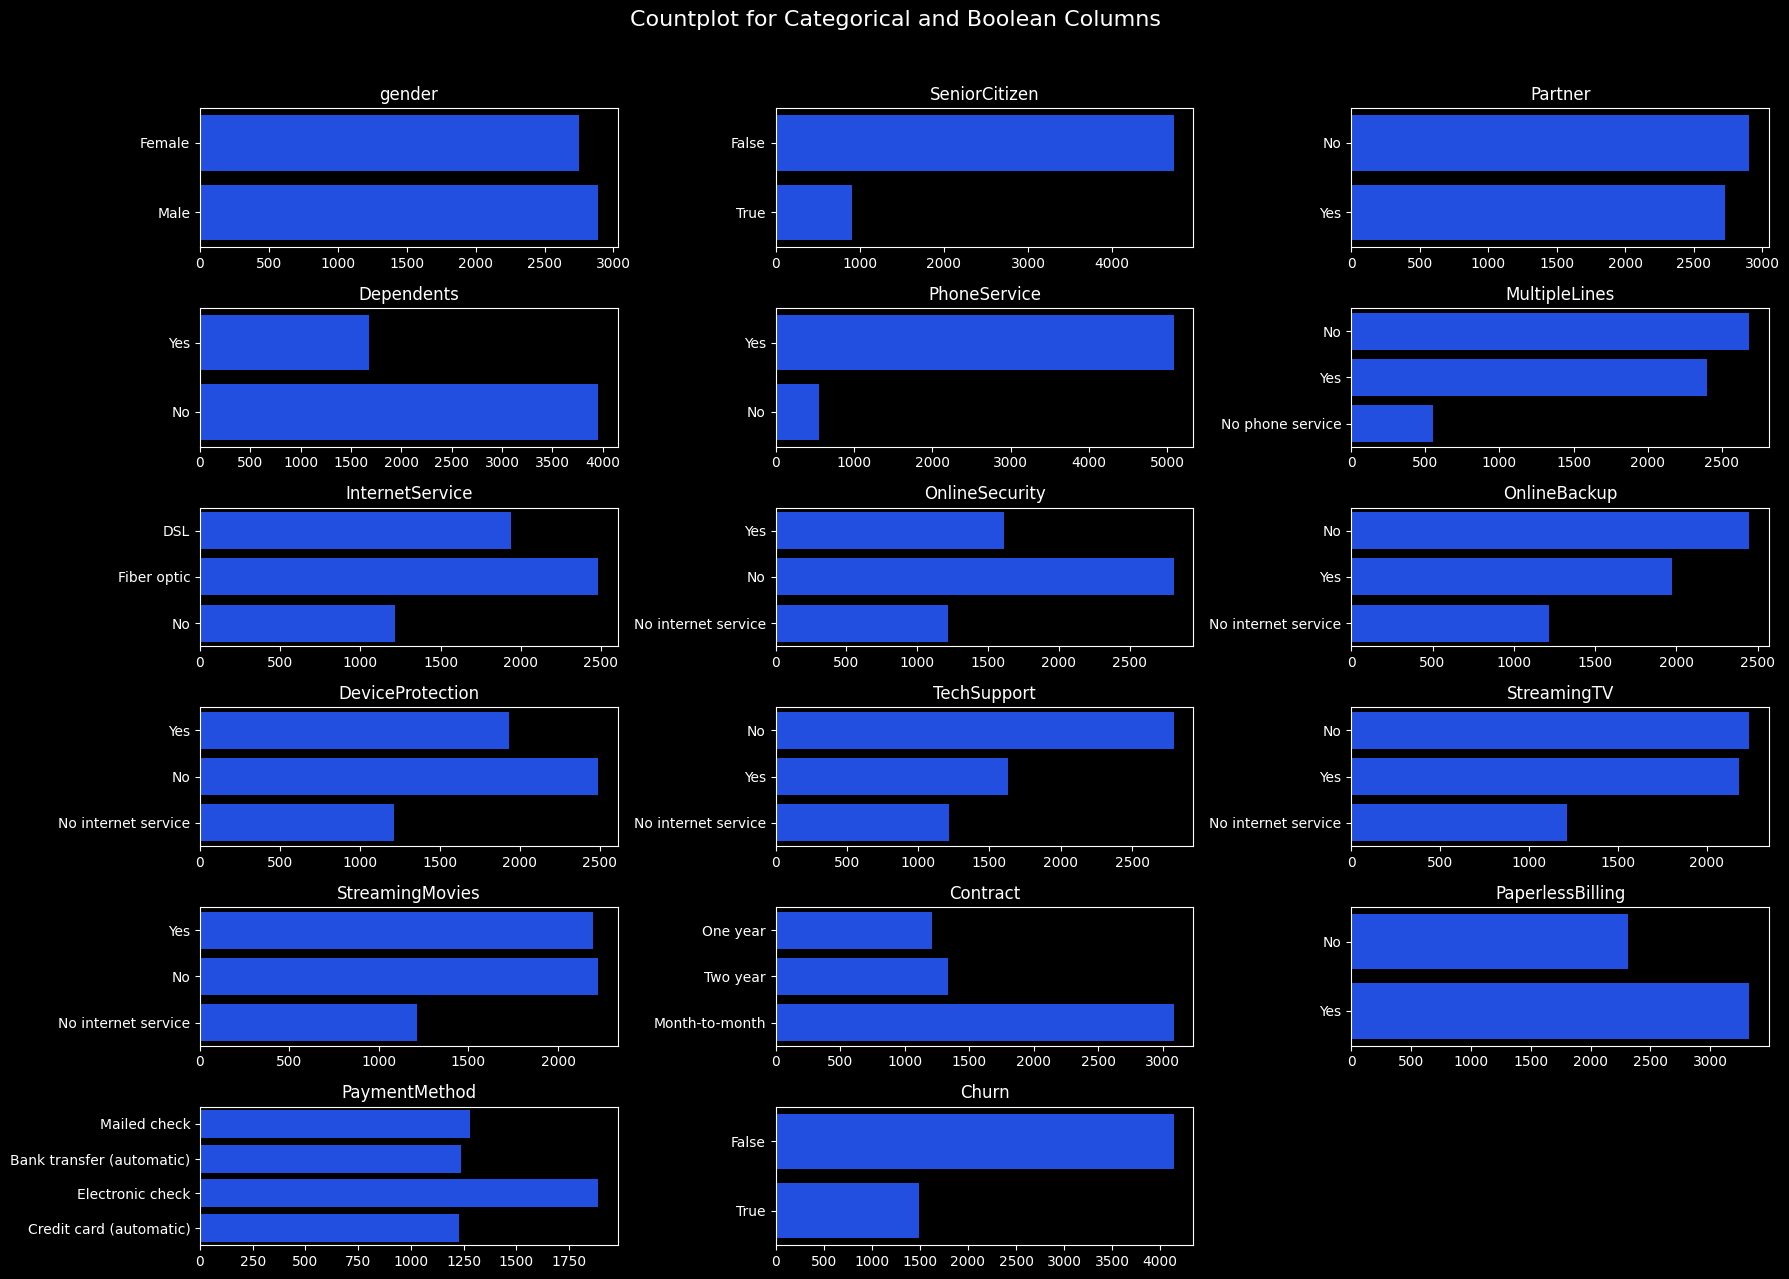

In [15]:
# Mengatur ukuran figure dan layout grid
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 13))
fig.suptitle('Countplot for Categorical and Boolean Columns', fontsize=16)

# Flatten axes agar bisa iterasi dengan mudah
axes = axes.flatten()

# Membuat countplot untuk setiap kolom
for i, col in enumerate(category_columns):
    sns.countplot(train, y=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Menghilangkan axes kosong jika kolom tidak cukup
for j in range(len(category_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Mengatur layout dan spasi
plt.show()

Ada beberapa pola menarik yang kita dapatkan dari countplot di atas yang kita tidak melihatnya dari ringkasan statistika deskriptif:

- Jumlah pealnggan setia Telco hampir 3x dari yang berhenti berlangganan, data target cukup tidak imbang. Mungkin perlu diatasi untuk analisis lebih lanjut.
- Jumlah pelanggan Telco yang berjenis kelamin pria dan wanita hampir sama.
- Jumlah pelanggan Telco yang memiliki pasangan dan yang tidak hampir sama.
- Jumlah pelanggan Telco yang menggunakan paket telepon multisaluran hampir sama dengan yang 1 saluran.
- Pengguna paket internet Telco yang berlangganan layanan streaming hampir sama banyaknya dengan yang tidak pakai streaming.
- Pengguna paket internet Telco dengan pencadangan online hampir sama banyaknya dengan yang tidak berlangganan layanan pencadangan online. Pola yang serupa juga terdapat pada proteksi device.
- Jumlah pengguna paket internet Telco dengan dukungan teknis hampir 2 kali lipat dari pengguna yang tidak berlangganan layanan dukungan teknis. Pola yang serupa juga terdapat pada keamanan online.

#### Analisis Bivariat

##### Atribut Numerik

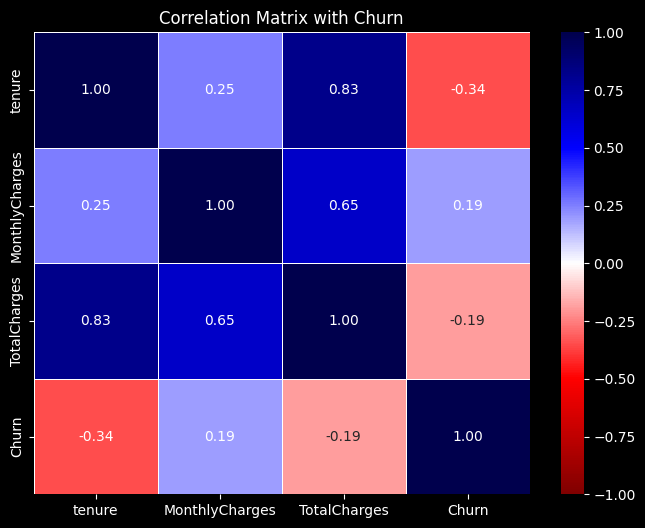

In [16]:
# Menghitung korelasi dengan kolom 'Churn'
correlation_matrix = train[numeric_columns + ['Churn']].corr()

# Menampilkan korelasi dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic_r', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix with Churn')
plt.show()

Interpretasi Matriks Korelasi dengan Churn

1. **tenure dan Churn**:
   - **Nilai Korelasi**: -0.34
   - **Interpretasi**: Terdapat korelasi negatif yang cukup lemah antara tenure dan churn, menunjukkan bahwa semakin lama pelanggan berlangganan, semakin kecil kemungkinan mereka untuk churn. Pelanggan yang sudah lama cenderung lebih loyal, meskipun pengaruhnya lemah.

2. **MonthlyCharges dan Churn**:
   - **Nilai Korelasi**: 0.19
   - **Interpretasi**: Terdapat korelasi positif lemah antara biaya bulanan dan churn. Pelanggan dengan biaya bulanan lebih tinggi sedikit lebih cenderung untuk churn dibandingkan pelanggan dengan biaya bulanan lebih rendah, meskipun pengaruhnya lemah.

3. **TotalCharges dan Churn**:
   - **Nilai Korelasi**: -0.19
   - **Interpretasi**: Terdapat korelasi negatif lemah antara total biaya dan churn. Pelanggan dengan total biaya yang lebih tinggi cenderung sedikit lebih loyal, meskipun pengaruhnya lemah.

4. **Korelasi Antara Variabel Lain**:
   - **tenure dan TotalCharges**: Korelasi yang sangat kuat (0.83), karena total biaya adalah akumulasi dari biaya bulanan kali lama berlangganan.
   - **MonthlyCharges dan TotalCharges**: Korelasi positif cukup kuat (0.65), karena pelanggan dengan biaya bulanan tinggi cenderung memiliki total biaya yang lebih tinggi.

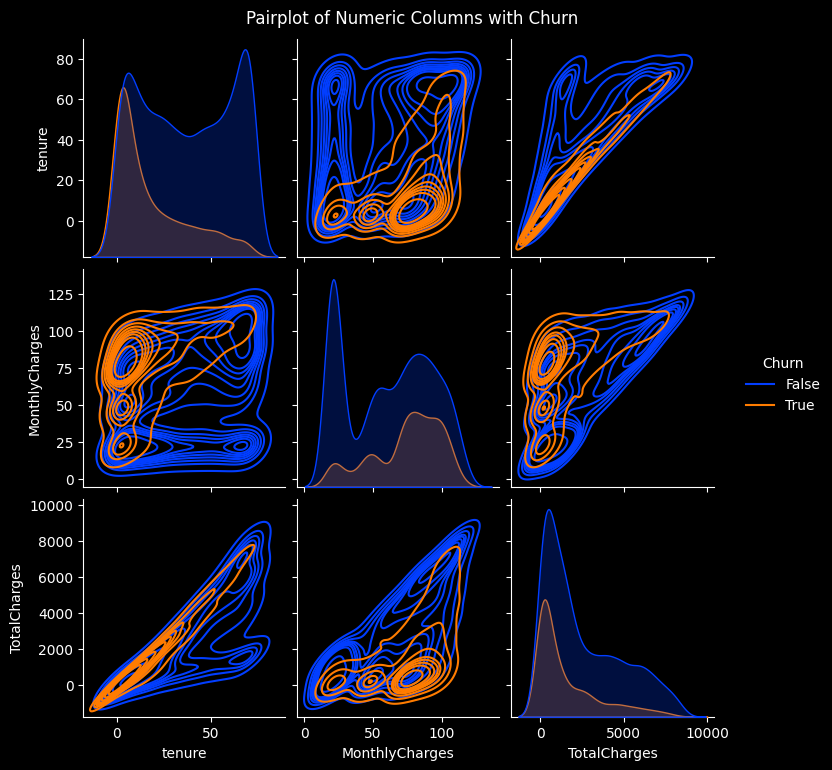

In [17]:
# Membuat pairplot untuk kolom numerik dan target 'Churn'
sns.pairplot(train[numeric_columns + ['Churn']], hue='Churn', kind='kde')
plt.suptitle('Pairplot of Numeric Columns with Churn', y=1.02)

# Menampilkan plot
plt.show()

Interpretasi Pairplot Numeric Columns dengan Churn

Visualisasi pairplot ini menunjukkan hubungan antara kolom numerik **(`tenure`, `MonthlyCharges`, `TotalCharges`)** dengan variabel target **(`Churn`)**, menggunakan warna untuk membedakan churn (oranye) dan non-churn (biru).

Hubungan Bivariat:
1. **`tenure`**
   - Distribusi pelanggan **non-churn** bimodal dengan puncak **`tenure`** yang ekstrem tinggi dan ekstrem rendah.
   - Pelanggan yang churn lebih banyak ditemukan pada **`tenure`** rendah, mengindikasikan churn lebih sering terjadi di awal masa berlangganan.

2. **`MonthlyCharges`**
   - Pelanggan churn lebih banyak ditemukan pada **`MonthlyCharges`** yang relatif tinggi (di atas \$80).
   - Pelanggan **non-churn** tersebar pada rentang biaya bulanan yang lebih rendah hingga sedang (\$10–\$40) atau yang relatif tinggi (\$70-\$120).

3. **`TotalCharges`**
   - Pelanggan baik churn maupun tidak lebih terkonsentrasi pada **`TotalCharges`** rendah, sekali lagi mengindikasikan churn lebih sering terjadi di awal masa berlangganan. Mencerminkan pelanggan dengan tagihan bulanan rendah yang cenderung lebih setia dan tingginya tingkat churn pelanggan yang tagihan bulanannya tinggi

Hubungan Multivariat:  
- Tidak terlihat hubungan yang signifikan antara **`MonthlyCharges`** dan **`tenure`** untuk pelanggan yang masih berlangganan.
- Kebanyakan pelanggan churn adalah mereka yang tagihan bulanannya tinggi namun masa berlangganannya cukup rendah, sedangkan yang tagihan bulanannya rendah cenderung cepat berhenti berlangganan.
- Ada hubungan linear yang sangat jelas antara **`TotalCharges`** dan **`tenure`** pada pelanggan churn, untuk yang tidak churn juga sama kecuali ada cukup banyak pelanggan dengan masa tenure yang tinggi namun total tagihannya rendah, mungkin ini alasan dibalik kesetiaan mereka.
- Pelanggan dengan **`TotalCharges`** yang tinggi **`MonthlyCharges`** yang tinggi, namun total tagihan rendah bukan berarti tagihan bulanannya rendah juga. Ini mengindikasikan masa berlangganan yang cukup rendah.

Saran:
Strategi untuk meningkatkan retensi dapat difokuskan pada pelanggan dengan tagihan bulanan tinggi (\$70-\$120) karena tingkat churnnya tinggi.

##### Atribut Kategorik

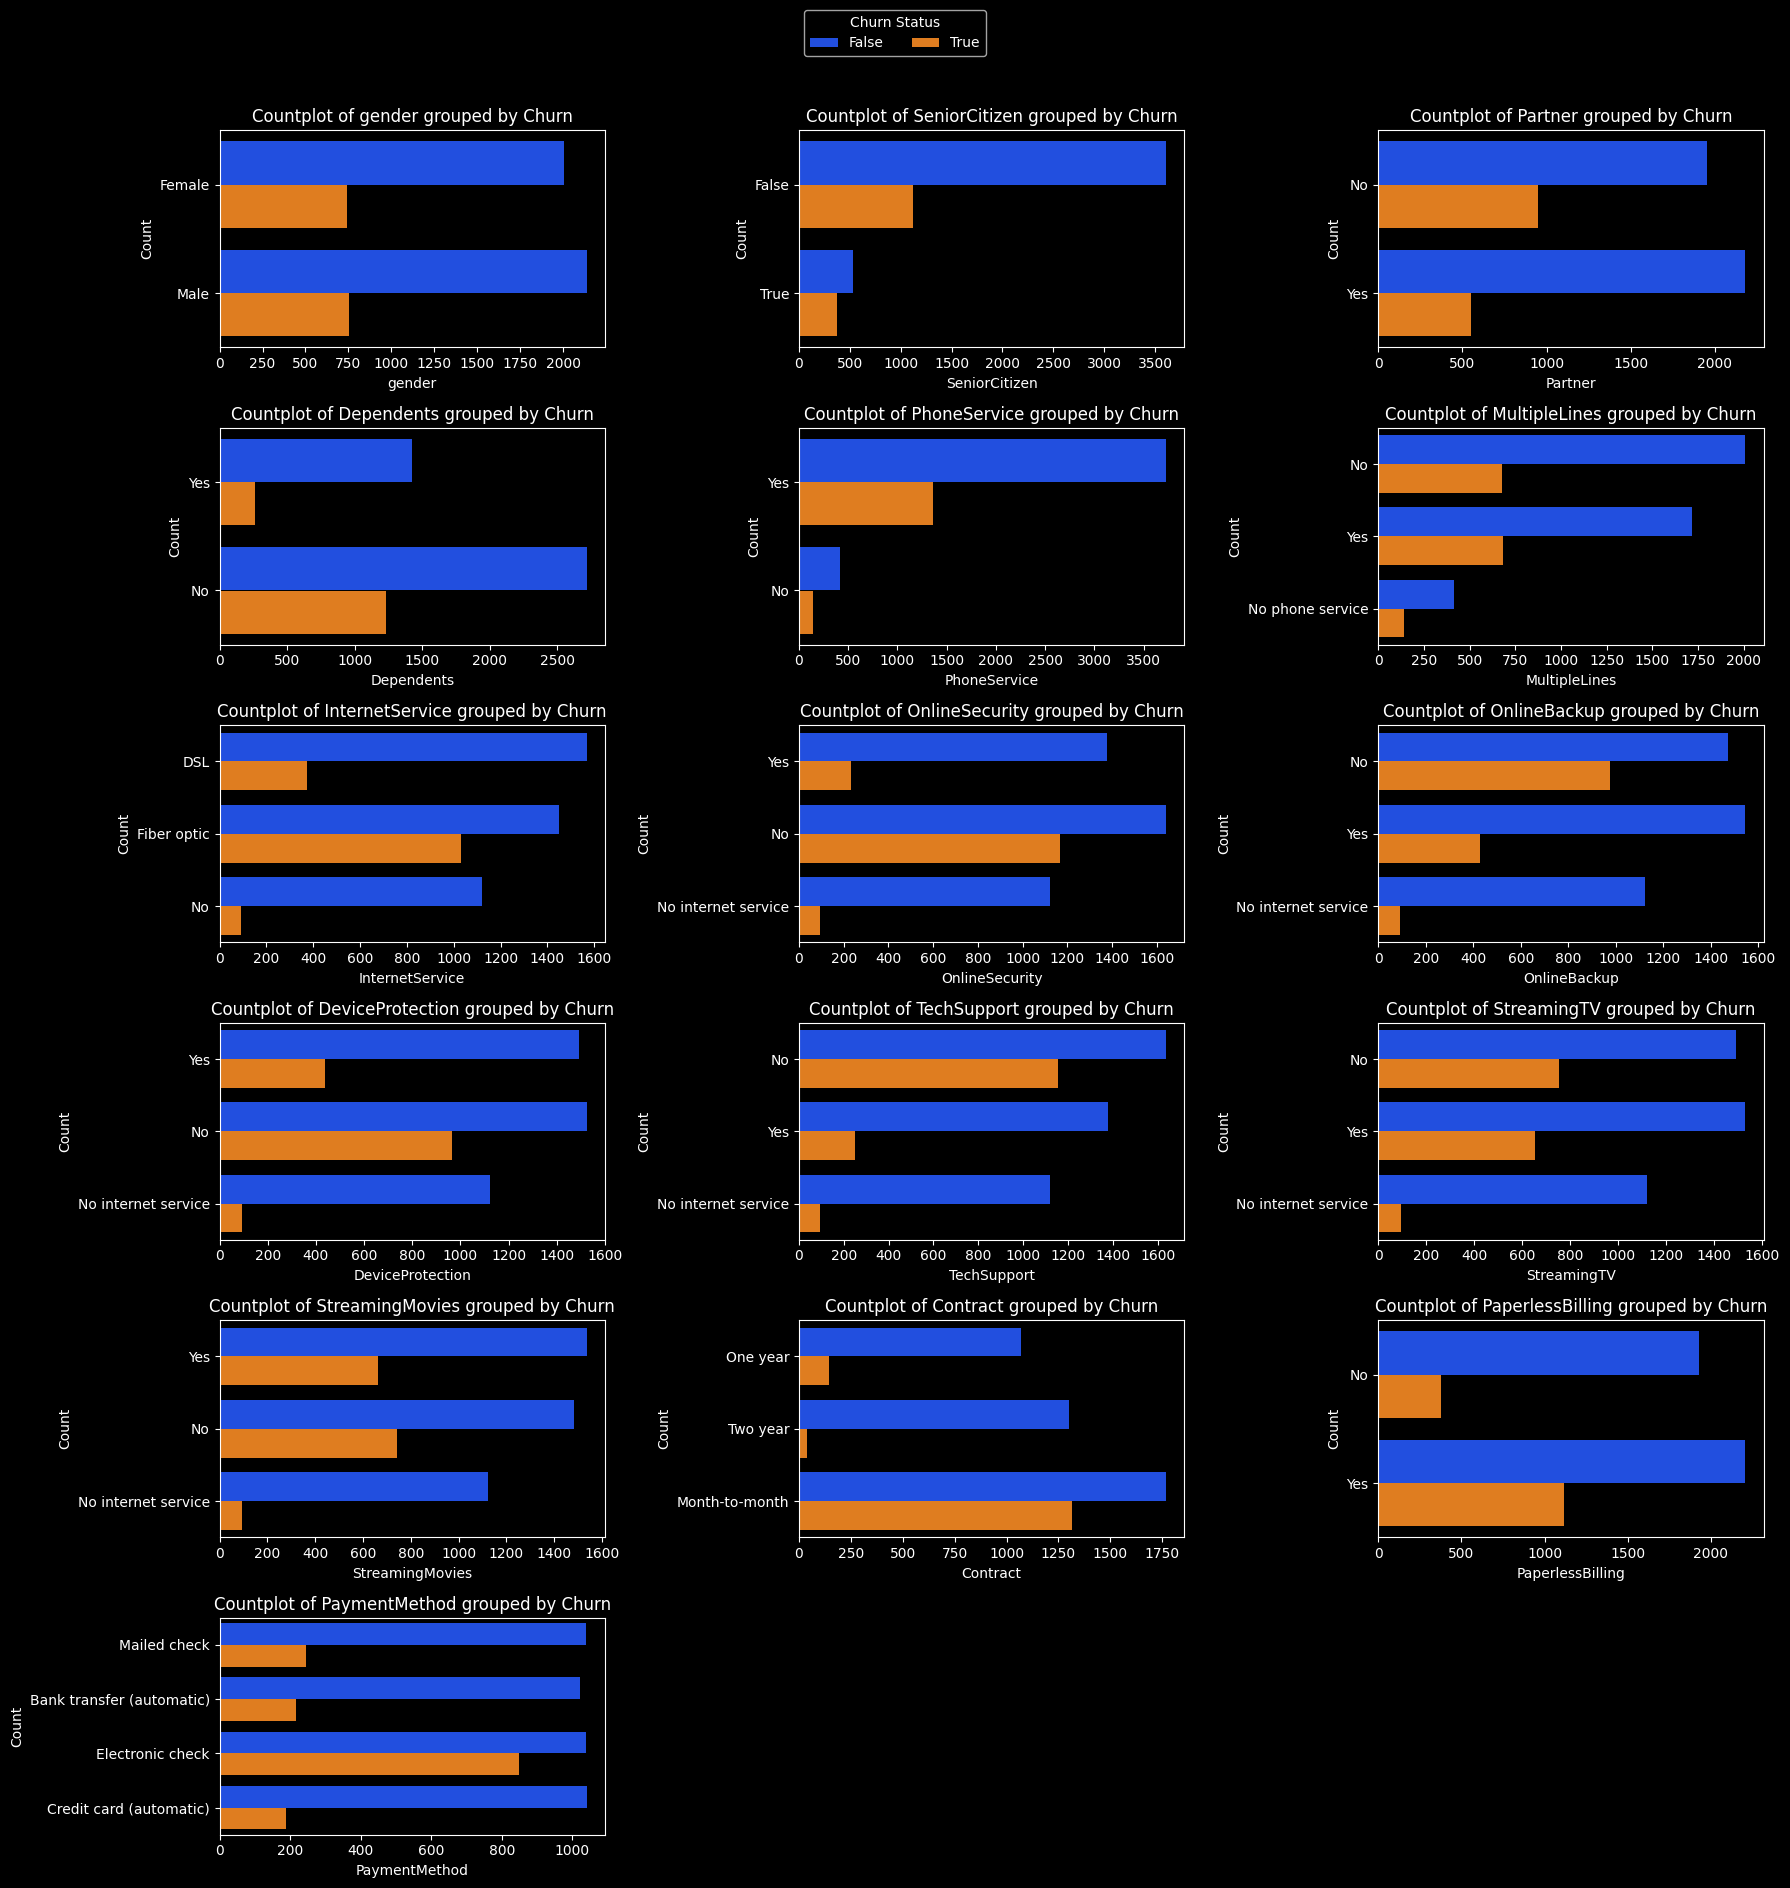

In [18]:
#  membuat countplot untuk setiap kolom kategorik dengan grup berdasarkan churn
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 18))
axes = axes.flatten()

for i, column in enumerate(category_columns[:-1]):
    sns.countplot(data=train, y=column, hue='Churn', ax=axes[i])
    axes[i].set_title(f'Countplot of {column} grouped by Churn')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].legend().remove()  # Menghapus legend dari masing-masing subplot

# Menghilangkan axes kosong jika kolom tidak cukup
for j in range(len(category_columns[:-1]), len(axes)):
    fig.delaxes(axes[j])

# Menambahkan legend global
fig.legend(
    labels=["False", "True"],  # Sesuaikan label sesuai dataset
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=2,
    title="Churn Status"
)

plt.tight_layout()
plt.show()

Interpretasi Countplot Kolom Kategorik per Kategori Churn

Ada beberapa pola menarik yang kita dapatkan dari countplot di atas yang kita tidak melihatnya dari ringkasan statistika deskriptif dan countplot sebelumnya:

- Secara keseluruhan jumlah pelanggan yang masih berlangganan lebih banyak hampir 3 kali lipat daripada yang sudah berhenti. Namun ternyata ada beberapa kategori yang jumlah pelanggan churn-nya cukup tinggi relatif terhadap yang setia, diantaranya:
  - pengguna Fiber optic
  - pengguna paket internet yang tidak menggunakan layanan keamanan online
  - pengguna paket internet yang tidak menggunakan layanan pencadangan online
  - pengguna paket internet yang tidak menggunakan layanan proteksi device
  - pengguna paket internet yang tidak menggunakan layanan dukungan teknis
  - pengguna yang membayar tiap bulan
  - pengguna yang menggunakan metode pembayaran electronic check
  - pengguna senior
- Ada beberapa kolom yang kelihatannya tidak berkorelasi dengan churn dilihat dari proporsi pelanggan churn dan tidak churn-nya relatif sama antar kategorinya, yaitu gender, MultipleLines, dan PhoneService.
- Tidak terlihat perbedaan proporsi pelanggan churn dan tidak churn pada kolom StreamingTV dan StreamingMovies khusus untuk pengguna yang berlangganan paket internet .

#### Deep Dive EDA


##### Pengaruh jumlah layanan yang digunakan
Mengetahui rata-rata tagihan bulanan, churn rate, dan jumlah pelanggan berdasarkan jumlah paket/layanan yang digunakan pelanggan? serta bagaimana jumlah paket/layanan mempengaruhi rata-rata tagihan bulanan & churn rate?

In [19]:
# membuat kolom jumlah layanan yang digunakan pelanggan
service_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
train['NumOfServices'] = train[service_columns].apply(lambda row: sum(row == 'Yes') + sum(row == True) + sum(row == 'Fiber optic') + sum(row == 'DSL'), axis=1)

# menghitung rata-rata tagihan bulanan dan churn rate berdasarkan jumlah layanan
result = train.groupby('NumOfServices').agg(
    avg_monthlycharges = ('MonthlyCharges', 'mean'),
    churn_rate = ('Churn', lambda x: (x == True).mean() * 100), # menghitung churn rate dalam persentase
    count = ('customerID','nunique')
).reset_index()
result

,NumOfServices,avg_monthlycharges,churn_rate,count
0,1,20.260440,11.088911,1001
1,2,41.864828,31.948424,698
2,3,61.811404,44.444444,684
3,4,69.367952,34.973404,752
4,5,78.549314,30.727023,729
5,6,86.777740,26.986301,730
6,7,93.635262,22.242315,553
7,8,99.034227,12.933754,317
8,9,104.204706,5.882353,170


Dari tabel di atas kita bisa melihat bahwa mayoritas pelanggan menggunakan tidak banyak macam layanan, semakin banyak layanan yang digunakan jumlah penggunanya cenderung menurun.

Rata-rata tagihan bulanan berbandingan lurus dengan jumlah layanan yang pelanggan gunakan, kenaikannya sekitar \$20 untuk setiap layanan, tetapi relatif terus berkurang saat jumlah layanannya lebih dari 3 terlepas layanan apa yang digunakan. Mungkin ini mengindikasikan adanya diskon untuk pelanggan yang berlangganan lebih dari 2 layanan.

kita juga bisa melihat bahwa churn rate untuk pelanggan relatif rendah (~11%)untuk pelanggan yang hanya berlangganan 1 layanan, kemudian meningkat drastis hingga hampir 45% untuk pelanggan yang menggunakan 2 layanan, namun setelah itu semakin bertambah jumlah layanan pelanggan, churn ratenya terus menurus. Ini bisa mengindikasikan bahwa diskon yang berlaku untuk pengguna lebih dari 2 layanan efektif menekan churn rate.

agar mudah dilihat kita bisa melihat visualisasi di bawah

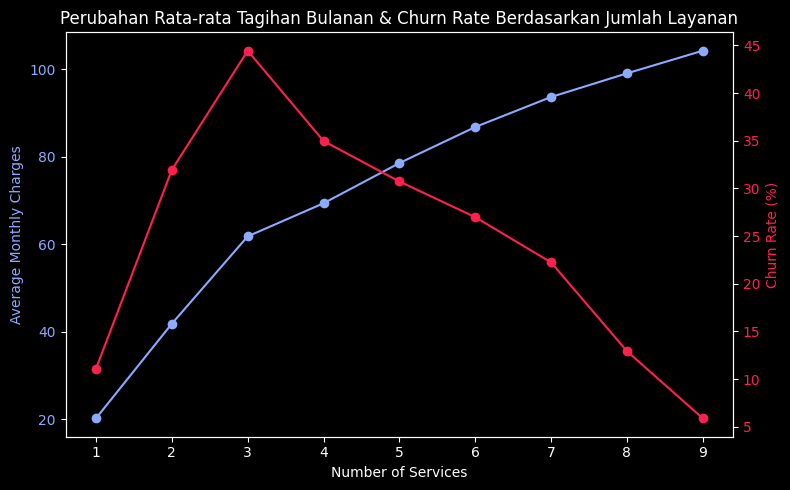

In [20]:
# membuat figure dan axis untuk chart
fig, ax1 = plt.subplots(figsize=(8, 5))

# plot avg_totalcharges di sumbu Y pertama
ax1.plot(result['NumOfServices'], result['avg_monthlycharges'], color='#8CABFF', marker='o', label='Average Monthly Charges')
ax1.set_xlabel('Number of Services')
ax1.set_ylabel('Average Monthly Charges', color='#8CABFF')
ax1.tick_params(axis='y', labelcolor='#8CABFF')

# membuat sumbu Y kedua untuk churn rate
ax2 = ax1.twinx()
ax2.plot(result['NumOfServices'], result['churn_rate'], color='#FF204E', marker='o', label='Churn Rate (%)')
ax2.set_ylabel('Churn Rate (%)', color='#FF204E')
ax2.tick_params(axis='y', labelcolor='#FF204E')

# menambahkan judul dan layout
plt.title('Perubahan Rata-rata Tagihan Bulanan & Churn Rate Berdasarkan Jumlah Layanan')
fig.tight_layout()

plt.show()

Terlihat bahwa `UnknownBill` berdistribusi normal dengan mean \$0,74 dan standar deviasi sekitar \$67 namun rentangnya cukup lebar sehingga mengakibatkan ada banyak outlier.

### Data Preprocessing

##### Handle Duplicates, Missing Values & Outliers

Karena saat EDA tadi kita sudah melihat bahwa data tidak mengandung duplikat & outlier maka tidak perlu kita handle disini.
Kita sudah menghandle missing value sebelumnya untuk mengoreksi tipe kolom `TotalCharges` agar bisa dieksplorasi.


In [21]:
# pisahkan kembali fitur dan target
X_train = train.drop(['Churn'], axis = 1)
y_train = train['Churn']

#### Feature Engineering  
Waktu EDA tadi kita sempat membuat kolom baru `NumOfServices` untuk eksplorasi lebih jauh. Kita akan coba pertahankan kolom tersebut untuk analisis lebih lanjut.

In [22]:
# menambahkan kolom baru ke list kolom numerik
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 2142 to 860
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   bool   
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 
 17

##### Categorical Encoding  
Kita akan membedakan fitur untuk masing-masing model. Untuk logistic regression akan dilakukan dummy encoding pada kolom kategorik karena cocok dan karena kardinalitas kolom kategorik rendah maka tidak akan menimbulkan curse of dimensionality.  
Untuk tree based models akan digunakan label encoding. tapi di kodingan menggunakan ordinal encoding sebagai alternatif, Outputnya sama tapi dengan ordinal encoding kita bisa encode banyak kolom sekaligus.

In [23]:
# transformasi kolom binary dengan ketentuan Yes menjadi True dan No menjadi False
yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in yes_no_columns:
    X_train[col] = X_train[col].map({'Yes': True, 'No': False})

# encode semua kolom kategorik
category_columns_for_encode = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

onehot_encoder = OneHotEncoder(drop='first', dtype='bool', sparse_output=False)
X_train_logr = X_train.copy()
encoded_data = onehot_encoder.fit_transform(X_train_logr[category_columns_for_encode])
encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoder.get_feature_names_out(category_columns_for_encode), index=X_train_logr.index)
X_train_logr = X_train_logr.drop(category_columns_for_encode, axis=1)
X_train_logr = pd.concat([X_train_logr, encoded_df], axis=1)

ordinal_encoder = OrdinalEncoder(dtype='int')
X_train_tree = X_train.copy()
X_train_tree[category_columns_for_encode] = ordinal_encoder.fit_transform(X_train_tree[category_columns_for_encode])

display(X_train_logr.head())
display(X_train_tree.head())

,customerID,tenure,MonthlyCharges,TotalCharges,NumOfServices,gender_Male,SeniorCitizen_True,Partner_True,Dependents_True,PhoneService_True,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_True,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,4223-BKEOR,21,64.85,1336.80,5,False,False,False,True,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,True
1623,6035-RIIOM,54,97.20,5129.45,6,False,False,False,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,True,False,False,False
6074,3797-VTIDR,1,23.45,23.45,1,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1362,2568-BRGYX,4,70.20,237.95,2,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
6754,2775-SEFEE,0,61.90,0.00,6,True,False,False,True,True,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumOfServices
2142,4223-BKEOR,0,0,0,1,21,1,0,0,2,0,2,0,0,2,1,0,3,64.85,1336.80,5
1623,6035-RIIOM,0,0,0,0,54,1,2,1,0,2,0,0,2,2,2,1,0,97.20,5129.45,6
6074,3797-VTIDR,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,2,23.45,23.45,1
1362,2568-BRGYX,1,0,0,0,4,1,0,1,0,0,0,0,0,0,0,1,2,70.20,237.95,2
6754,2775-SEFEE,1,0,0,1,0,1,2,0,2,2,0,2,0,0,2,1,0,61.90,0.00,6


##### Feature Scaling  
Kita akan menggunakan min max scaling supaya perhitungan jarak SMOTE-NC tepat.

In [24]:
minmax_scaler = MinMaxScaler()
X_train_logr[numeric_columns] = minmax_scaler.fit_transform(X_train_logr[numeric_columns])
X_train_tree[numeric_columns] = minmax_scaler.fit_transform(X_train_tree[numeric_columns])
display(X_train_logr.head())
display(X_train_tree.head())

,customerID,tenure,MonthlyCharges,TotalCharges,NumOfServices,gender_Male,SeniorCitizen_True,Partner_True,Dependents_True,PhoneService_True,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_True,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,4223-BKEOR,0.291667,0.464375,0.153924,0.500,False,False,False,True,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,True
1623,6035-RIIOM,0.750000,0.786746,0.590624,0.625,False,False,False,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,True,False,False,False
6074,3797-VTIDR,0.013889,0.051819,0.002700,0.000,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1362,2568-BRGYX,0.055556,0.517688,0.027398,0.125,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
6754,2775-SEFEE,0.000000,0.434978,0.000000,0.625,True,False,False,True,True,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumOfServices
2142,4223-BKEOR,0,0,0,1,0.291667,1,0,0,2,0,2,0,0,2,1,0,3,0.464375,0.153924,0.500
1623,6035-RIIOM,0,0,0,0,0.750000,1,2,1,0,2,0,0,2,2,2,1,0,0.786746,0.590624,0.625
6074,3797-VTIDR,1,0,1,0,0.013889,0,1,0,0,0,0,0,0,0,0,1,2,0.051819,0.002700,0.000
1362,2568-BRGYX,1,0,0,0,0.055556,1,0,1,0,0,0,0,0,0,0,1,2,0.517688,0.027398,0.125
6754,2775-SEFEE,1,0,0,1,0.000000,1,2,0,2,2,0,2,0,0,2,1,0,0.434978,0.000000,0.625


##### Feature Selection  
Kita akan menghapus CustomerID karena ID tidak mempengaruhi target.  
Untuk logistic regression, kita perlu menghindari multikolinearitas. Karena ada kolom baru, maka kita akan menghitung VIF dan melakukan analisis korelasi lagi.

In [25]:
# hapus ID
X_train_logr = X_train_logr.drop(['customerID'], axis=1)
X_train_tree = X_train_tree.drop(['customerID'], axis=1)

# menghitung skor VIF
X = add_constant(X_train_logr[numeric_columns])

vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])],
         index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,tenure,5.893364
2,MonthlyCharges,5.243608
3,TotalCharges,10.222377
4,NumOfServices,5.245091


Skor VIF kolom `TotalCharges` tinggi, yang lainnya moderat. Akan dipertimbangkan untuk dibuang.

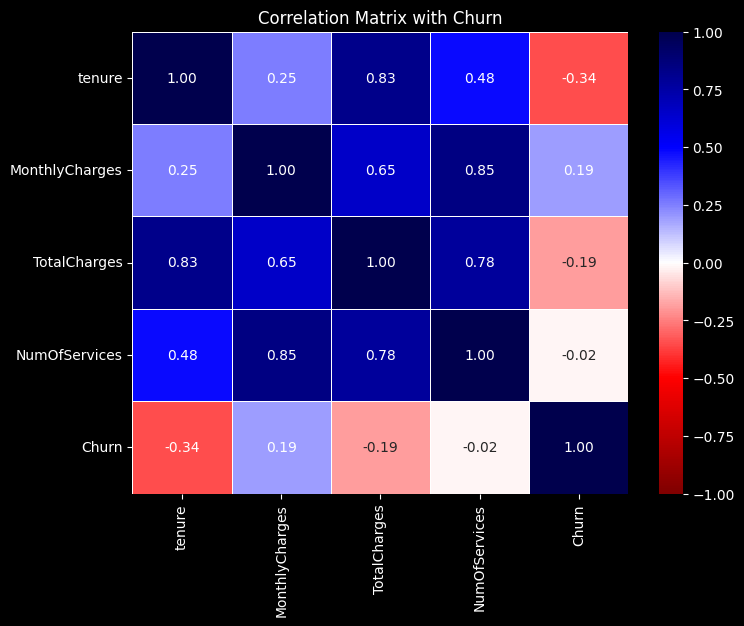

In [26]:
# Menghitung korelasi dengan kolom 'Churn'
correlation_matrix = pd.concat([X_train_logr[numeric_columns], y_train], axis=1).corr()

# Menampilkan korelasi dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic_r', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix with Churn')
plt.show()

- Terdapat korelasi yang tinggi antara `tenure` dan `TotalCharges` dengan nilai korelasi = `**0.83**`.  
- Terdapat korelasi yang tinggi antara `NumOfServices` dan `MonthlyCharges` dengan nilai korelasi = `**0.85**`.  
- Terdapat korelasi yang cukup tinggi antara `NumOfServices` dan `TotalCharges` dengan nilai korelasi = `**0.78**`.  

Saya akan pertimbangkan untuk menghapus `NumOfServices` karena nilai korelasinya dengan target sangat rendah. Ini bukan berarti tidak ada korelasi, karena jika kita lihat pada visualisasi deep dive EDA, terdapat hubungan non linear yang jelas antara `NumOfServices` dengan target yang naik kemudian turun sehingga seolah-olah tidak berhubungan jika dihitung korelasinya. Hubungan non linear tidak cocok untuk regresi logistik.

Saya akan pertimbangkan untuk menghapus `TotalCharges` karena jika dilihat pada pairplot hubungannya dengan target, tidak terdapat perbedaan distribusi yang signifikan antara pelanggan churn dan tidak, selain itu nilai korelasinya juga rendah.

In [27]:
# menghapus kolom TotalCharges
X_train_logr = X_train_logr.drop(['TotalCharges','NumOfServices'], axis=1)
numeric_columns_logr = X_train_logr.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [28]:
# menghitung skor VIF
X = add_constant(X_train_logr[numeric_columns_logr])

vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])],
         index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,tenure,1.068851
2,MonthlyCharges,1.068851


Semua skor VIF kolom rendah, tampaknya sudah tidak ada multikolinearitas antar kolom numerik.

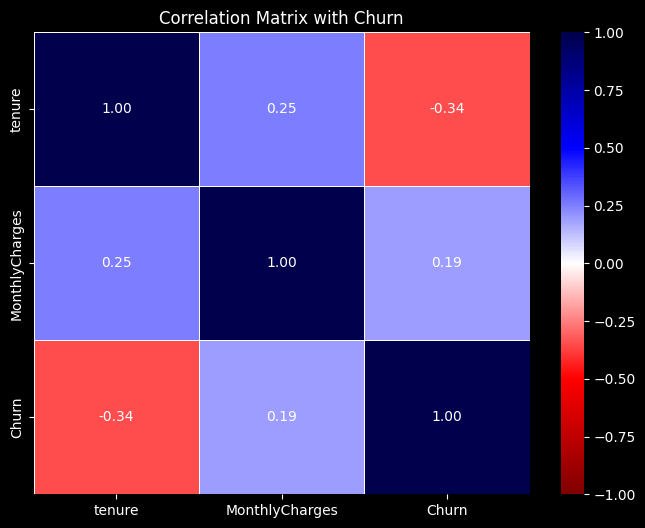

In [30]:
# Menghitung korelasi dengan kolom 'Churn'
correlation_matrix = pd.concat([X_train_logr[numeric_columns_logr], y_train], axis=1).corr()

# Menampilkan korelasi dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic_r', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix with Churn')
plt.show()

Sudah tidak ada multikolinearitas antar kolom numerik.


In [31]:
# cek metadata data train
display(X_train_logr.info())
display(X_train_tree.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 2142 to 860
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 5634 non-null   float64
 1   MonthlyCharges                         5634 non-null   float64
 2   gender_Male                            5634 non-null   bool   
 3   SeniorCitizen_True                     5634 non-null   bool   
 4   Partner_True                           5634 non-null   bool   
 5   Dependents_True                        5634 non-null   bool   
 6   PhoneService_True                      5634 non-null   bool   
 7   MultipleLines_No phone service         5634 non-null   bool   
 8   MultipleLines_Yes                      5634 non-null   bool   
 9   InternetService_Fiber optic            5634 non-null   bool   
 10  InternetService_No                     5634 non-null   bool   
 11  OnlineS

None

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 2142 to 860
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5634 non-null   int64  
 1   SeniorCitizen     5634 non-null   int64  
 2   Partner           5634 non-null   int64  
 3   Dependents        5634 non-null   int64  
 4   tenure            5634 non-null   float64
 5   PhoneService      5634 non-null   int64  
 6   MultipleLines     5634 non-null   int64  
 7   InternetService   5634 non-null   int64  
 8   OnlineSecurity    5634 non-null   int64  
 9   OnlineBackup      5634 non-null   int64  
 10  DeviceProtection  5634 non-null   int64  
 11  TechSupport       5634 non-null   int64  
 12  StreamingTV       5634 non-null   int64  
 13  StreamingMovies   5634 non-null   int64  
 14  Contract          5634 non-null   int64  
 15  PaperlessBilling  5634 non-null   int64  
 16  PaymentMethod     5634 non-null   int64  
 17

None

#### Imbalance Handling  
Disini karena datanya cukup kecil, jadi saya akan melakukan oversampling.  
karena Kebanyakan fitur bertipe kategorik, maka saya akan menggunakan teknik SMOTE-NC.  
Namun saya tidak ingin meng-generate data terlalu banyak, jadi saya akan menggunakan gabungan undersampling dan oversampling.

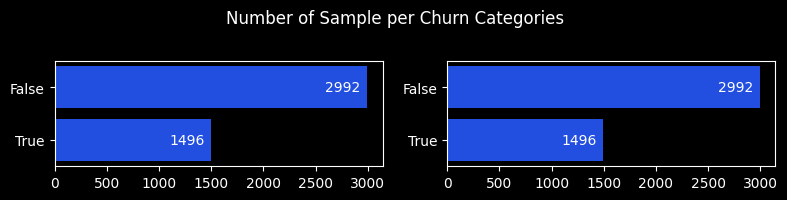

In [32]:
# undersample dengan rasio 2:1
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled_logr, y_resampled = undersampler.fit_resample(X_train_logr, y_train)
X_resampled_tree, y_resampled = undersampler.fit_resample(X_train_tree, y_train)

# mengatur ukuran figure dan layout grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
fig.suptitle('Number of Sample per Churn Categories', fontsize=12)

# flatten axes agar bisa iterasi dengan mudah
axes = axes.flatten()
col = 'Churn'

# membuat countplot untuk setiap kolom
for i in range(2):
  sns.countplot(pd.DataFrame(y_resampled), y=col, ax=axes[i])
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')

  # menambahkan label di setiap bar
  for container in axes[i].containers:
    axes[i].bar_label(container, padding=-30)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Mengatur layout dan spasi
plt.show()

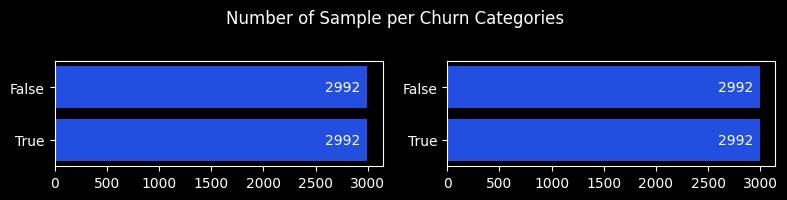

In [33]:
# memasukkan kolom kategorik dalam list
category_columns_tree = X_resampled_tree.select_dtypes(include=['int64']).columns.tolist()
category_columns_logr = X_resampled_logr.select_dtypes(include=['bool']).columns.tolist()

# perlu ubah tipe kolom hasil encoding menjadi category
for col in category_columns_tree:
  X_resampled_tree[col] = X_resampled_tree[col].astype('category')

# oversampling dengan SMOTE-NC
smote_nc_tree = SMOTENC(categorical_features = category_columns_tree, random_state=42)
smote_nc_logr = SMOTENC(categorical_features = category_columns_logr, random_state=42)
X_smoted_tree, y_smoted = smote_nc_tree.fit_resample(X_resampled_tree, y_resampled)
X_smoted_logr, y_smoted = smote_nc_logr.fit_resample(X_resampled_logr, y_resampled)

# mengatur ukuran figure dan layout grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
fig.suptitle('Number of Sample per Churn Categories', fontsize=12)

# flatten axes agar bisa iterasi dengan mudah
axes = axes.flatten()
col = 'Churn'

# membuat countplot untuk setiap kolom
for i in range(2):
  sns.countplot(pd.DataFrame(y_smoted), y=col, ax=axes[i])
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')

  # menambahkan label di setiap bar
  for container in axes[i].containers:
    axes[i].bar_label(container, padding=-30)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Mengatur layout dan spasi
plt.show()

### Modeling

In [34]:
# kembalikan tipe kolom menjadi integer
for col in category_columns_tree:
  X_smoted_tree[col] = X_smoted_tree[col].astype('int')

# Inisialisasi model tanpa tuning hyperparameter
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
ab = AdaBoostClassifier(random_state=42)
xg = XGBClassifier(random_state=42)

lr_grid = LogisticRegression(random_state=42)
rf_grid = RandomForestClassifier(random_state=42)
ab_grid = AdaBoostClassifier(random_state=42)
xg_grid = XGBClassifier(random_state=42)

# hyperparameter untuk model logistic regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# hyperparameter untuk model random forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 10]
}

# hyperparameter untuk model adaboost
param_grid_ab = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1]
}

# hyperparameter untuk model XGBoost
param_grid_xg = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 5]
}

# Memilih metric
scoring = {'recall': 'recall', 'precision': 'precision'}

# Melakukan pengujian dengan 5-cross-validation pada data train
cv_results_lr = cross_validate(lr, X_smoted_logr, y_smoted, cv=5, scoring=scoring)
cv_results_rf = cross_validate(rf, X_smoted_tree, y_smoted, cv=5, scoring=scoring)
cv_results_ab = cross_validate(ab, X_smoted_tree, y_smoted, cv=5, scoring=scoring)
cv_results_xg = cross_validate(xg, X_smoted_tree, y_smoted, cv=5, scoring=scoring)

grid_lr = GridSearchCV(lr_grid, param_grid_lr, cv=5, verbose=1, refit='recall', scoring=scoring)
grid_rf = GridSearchCV(rf_grid, param_grid_rf, cv=5, verbose=1, refit='recall', scoring=scoring)
grid_ab = GridSearchCV(ab_grid, param_grid_ab, cv=5, verbose=1, refit='recall', scoring=scoring)
grid_xg = GridSearchCV(xg_grid, param_grid_xg, cv=5, verbose=1, refit='recall', scoring=scoring)

# fit model dengan keseluruhan data train
lr.fit(X_smoted_logr, y_smoted)
rf.fit(X_smoted_tree, y_smoted)
ab.fit(X_smoted_tree, y_smoted)
xg.fit(X_smoted_tree, y_smoted)

grid_lr.fit(X_smoted_logr, y_smoted)
grid_rf.fit(X_smoted_tree, y_smoted)
grid_ab.fit(X_smoted_tree, y_smoted)
grid_xg.fit(X_smoted_tree, y_smoted)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             refit='recall',
             scoring={'precision': 'precision', 'recall': 'recall'}, verbose=1)

Saya menggunakan metric recall dan precision untuk kasus ini. Recall menunjukkan berapa persentase pelanggan yang benar-benar churn diprediksi dengan benar oleh model, sedangkan precision menunjukkan berapa presentase pelanggan yang benar-benar churn dari semua pelanggan yang diprediksi churn.  
Precision yang rendah menunjukkan relatif banyak pelanggan yang setia justru diprediksi churn.  

Recall adalah metric utama pada kasus churn. Model dapat mencurangi nilai recall dengan menebak pelanggan churn sebanyak-banyaknya. Karena itu precision digunakan juga untuk mengecek kecurangan ini. Jika terjadi kecurangan recall, maka nilai precision menjadi rendah.  

Recall dan Precision bagus digunakan untuk data imbalance dengan target positif jauh lebih sedikit daripada negatif seperti kasus churn biasanya. sehingga cocok untuk evaluasi data aktual yang tidak seimbang.

### Evaluation

In [35]:
print("Performa Model Logistic Regression pada Data Train:")
print("Mean Recall:", cv_results_lr['test_recall'].mean())
print("Mean Precision:", cv_results_lr['test_precision'].mean())

print('\nPerforma Model Random Forest pada Data Train:')
print("Mean Recall:", cv_results_rf['test_recall'].mean())
print("Mean Precision:", cv_results_rf['test_precision'].mean())

print('\nPerforma Model Adaboost pada Data Train:')
print("Mean Recall:", cv_results_ab['test_recall'].mean())
print("Mean Precision:", cv_results_ab['test_precision'].mean())

print('\nPerforma Model XGBoost pada Data Train:')
print("Mean Recall:", cv_results_xg['test_recall'].mean())
print("Mean Precision:", cv_results_xg['test_precision'].mean())

print("\nPerforma Model Logistic Regression pada Data Train dengan tuning hyperparameter:")
print("Best Parameters (Recall):", grid_lr.best_params_)
y_smoted_pred_lr = grid_lr.best_estimator_.predict(X_smoted_logr)
train_recall = recall_score(y_smoted, y_smoted_pred_lr)
train_precision = precision_score(y_smoted, y_smoted_pred_lr)
print("Training Data - Recall:", train_recall)
print("Training Data - Precision:", train_precision)

print('\nPerforma Model Random Forest pada Data Train dengan tuning hyperparameter:')
print("Best Parameters (Recall):", grid_rf.best_params_)
y_smoted_pred_rf = grid_rf.best_estimator_.predict(X_smoted_tree)
train_recall = recall_score(y_smoted, y_smoted_pred_rf)
train_precision = precision_score(y_smoted, y_smoted_pred_rf)
print("Training Data - Recall:", train_recall)
print("Training Data - Precision:", train_precision)

print('\nPerforma Model Adaboost pada Data Train dengan tuning hyperparameter:')
print("Best Parameters (Recall):", grid_ab.best_params_)
y_smoted_pred_ab = grid_ab.best_estimator_.predict(X_smoted_tree)
train_recall = recall_score(y_smoted, y_smoted_pred_ab)
train_precision = precision_score(y_smoted, y_smoted_pred_ab)
print("Training Data - Recall:", train_recall)
print("Training Data - Precision:", train_precision)

print('\nPerforma Model XGBoost pada Data Train dengan tuning hyperparameter:')
print("Best Parameters (Recall):", grid_xg.best_params_)
y_smoted_pred_xg = grid_xg.best_estimator_.predict(X_smoted_tree)
train_recall = recall_score(y_smoted, y_smoted_pred_xg)
train_precision = precision_score(y_smoted, y_smoted_pred_xg)
print("Training Data - Recall:", train_recall)
print("Training Data - Precision:", train_precision)

Performa Model Logistic Regression pada Data Train:
Mean Recall: 0.7987973266480923
Mean Precision: 0.7508129218117024

Performa Model Random Forest pada Data Train:
Mean Recall: 0.8278479740481627
Mean Precision: 0.803922664017804

Performa Model Adaboost pada Data Train:
Mean Recall: 0.8255330791006192
Mean Precision: 0.75016211898803

Performa Model XGBoost pada Data Train:
Mean Recall: 0.8161411717410847
Mean Precision: 0.7858985553587237

Performa Model Logistic Regression pada Data Train dengan tuning hyperparameter:
Best Parameters (Recall): {'C': 10, 'solver': 'liblinear'}
Training Data - Recall: 0.8004679144385026
Training Data - Precision: 0.7519623233908949

Performa Model Random Forest pada Data Train dengan tuning hyperparameter:
Best Parameters (Recall): {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Training Data - Recall: 0.9498663101604278
Training Data - Precision: 0.8654080389768575

Performa Model Adaboost pada Data Train dengan tuning hyperparameter

Semua model memberikan hasil yang cukup baik pada data train, namun kedepannya masih bisa diimprove lagi dengan menggunakan lebih banyak data, data yang lebih bagus, teknik data cleaning/feture engineering yang tepat, atau menggunakan model lain.

Setelah Hyperparamater tuning, terdapat peningkatan performa yang relatif kecil kecuali pada random forest yang performanya sangat luar biasa. Model random forest sejauh ini adalah yang terbaik tapi kita akan lihat apakah model ini memberikan hasil yang terbaik pada data test.

## Test

### Data Preprocessing

In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1409 entries, 185 to 1161
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        1409 non-null   object 
 1   gender            1409 non-null   object 
 2   SeniorCitizen     1409 non-null   int64  
 3   Partner           1409 non-null   object 
 4   Dependents        1409 non-null   object 
 5   tenure            1409 non-null   int64  
 6   PhoneService      1409 non-null   object 
 7   MultipleLines     1409 non-null   object 
 8   InternetService   1409 non-null   object 
 9   OnlineSecurity    1409 non-null   object 
 10  OnlineBackup      1409 non-null   object 
 11  DeviceProtection  1409 non-null   object 
 12  TechSupport       1409 non-null   object 
 13  StreamingTV       1409 non-null   object 
 14  StreamingMovies   1409 non-null   object 
 15  Contract          1409 non-null   object 
 16  PaperlessBilling  1409 non-null   object 
 17

##### Handle Duplicates, Missing Values & Outliers

In [37]:
# sama seperti data train, missing value pada kolom TotalCharges menunjukkan pelanggan baru yang belum membayar
display(X_test.loc[df['TotalCharges'] == ' '])
display(X_test.loc[df['tenure'] == 0])

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,


In [38]:
# isi missing value tersebut dengan 0
X_test.loc[X_test['TotalCharges'] == ' ', 'TotalCharges'] = 0

#### Feature Engineering


In [39]:
# tambahkan kolom NumOfServices
service_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
X_test['NumOfServices'] = X_test[service_columns].apply(lambda row: sum(row == 'Yes') + sum(row == True) + sum(row == 'Fiber optic') + sum(row == 'DSL'), axis=1)

##### Categorical Encoding


In [40]:
# ubah dulu tipe kolom TotalCharges
X_test['TotalCharges'] = X_test['TotalCharges'].astype(float)

# ubah ke boolean
X_test['SeniorCitizen'] = X_test['SeniorCitizen'].astype(bool)
yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in yes_no_columns:
    X_test[col] = X_test[col].map({'Yes': True, 'No': False})

# # encode semua kolom kategorik
# category_columns = X_test.select_dtypes(include=['object','bool']).columns.tolist() # tidak memasukkan kolom Churn
# category_columns.insert(2, 'SeniorCitizen') # menyamakan dengan list sewaktu fit_transform

X_test_logr = X_test.copy()
encoded_data = onehot_encoder.transform(X_test_logr[category_columns_for_encode])
encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoder.get_feature_names_out(category_columns_for_encode), index=X_test_logr.index)
X_test_logr = X_test_logr.drop(category_columns_for_encode, axis=1)
X_test_logr = pd.concat([X_test_logr, encoded_df], axis=1)


X_test_tree = X_test.copy()
X_test_tree[category_columns_for_encode] = ordinal_encoder.transform(X_test_tree[category_columns_for_encode]) # [1:] untuk skip kolom 'CustomerID'

display(X_test_logr.head())
display(X_test_tree.head())

,customerID,tenure,MonthlyCharges,TotalCharges,NumOfServices,gender_Male,SeniorCitizen_True,Partner_True,Dependents_True,PhoneService_True,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_True,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
185,1024-GUALD,1,24.80,24.80,1,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
2715,0484-JPBRU,41,25.25,996.45,2,True,False,False,False,True,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False
3825,3620-EHIMZ,52,19.35,1031.70,1,False,False,True,True,True,False,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,True
1807,6910-HADCM,1,76.35,76.35,3,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
132,8587-XYZSF,67,50.55,3260.10,3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumOfServices
185,1024-GUALD,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,2,24.80,24.80,1
2715,0484-JPBRU,1,0,0,0,41,1,2,2,1,1,1,1,1,1,0,1,0,25.25,996.45,2
3825,3620-EHIMZ,0,0,1,1,52,1,0,2,1,1,1,1,1,1,2,0,3,19.35,1031.70,1
1807,6910-HADCM,0,0,0,0,1,1,0,1,0,0,2,0,0,0,0,0,2,76.35,76.35,3
132,8587-XYZSF,1,0,0,0,67,1,0,0,0,0,0,2,0,0,2,0,0,50.55,3260.10,3


##### Feature Scaling

In [41]:
# menyesuaikan transformasi terhadap data train
X_test_logr[numeric_columns] = minmax_scaler.transform(X_test_logr[numeric_columns])
X_test_tree[numeric_columns] = minmax_scaler.transform(X_test_tree[numeric_columns])
display(X_test_logr.head())
display(X_test_tree.head())

,customerID,tenure,MonthlyCharges,TotalCharges,NumOfServices,gender_Male,SeniorCitizen_True,Partner_True,Dependents_True,PhoneService_True,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_True,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
185,1024-GUALD,0.013889,0.065272,0.002856,0.000,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
2715,0484-JPBRU,0.569444,0.069756,0.114735,0.125,True,False,False,False,True,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False
3825,3620-EHIMZ,0.722222,0.010962,0.118794,0.000,False,False,True,True,True,False,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,True
1807,6910-HADCM,0.013889,0.578974,0.008791,0.250,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
132,8587-XYZSF,0.930556,0.321873,0.375380,0.250,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumOfServices
185,1024-GUALD,0,0,1,0,0.013889,0,1,0,0,0,0,0,0,0,0,1,2,0.065272,0.002856,0.000
2715,0484-JPBRU,1,0,0,0,0.569444,1,2,2,1,1,1,1,1,1,0,1,0,0.069756,0.114735,0.125
3825,3620-EHIMZ,0,0,1,1,0.722222,1,0,2,1,1,1,1,1,1,2,0,3,0.010962,0.118794,0.000
1807,6910-HADCM,0,0,0,0,0.013889,1,0,1,0,0,2,0,0,0,0,0,2,0.578974,0.008791,0.250
132,8587-XYZSF,1,0,0,0,0.930556,1,0,0,0,0,0,2,0,0,2,0,0,0.321873,0.375380,0.250


##### Feature Selection


In [42]:
# menghapus kolom sesuai data train
X_test_logr = X_test_logr.drop(['customerID', 'TotalCharges', 'NumOfServices'], axis=1)
X_test_tree = X_test_tree.drop(['customerID'], axis=1)
display(X_test_logr.info())
display(X_test_tree.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1409 entries, 185 to 1161
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 1409 non-null   float64
 1   MonthlyCharges                         1409 non-null   float64
 2   gender_Male                            1409 non-null   bool   
 3   SeniorCitizen_True                     1409 non-null   bool   
 4   Partner_True                           1409 non-null   bool   
 5   Dependents_True                        1409 non-null   bool   
 6   PhoneService_True                      1409 non-null   bool   
 7   MultipleLines_No phone service         1409 non-null   bool   
 8   MultipleLines_Yes                      1409 non-null   bool   
 9   InternetService_Fiber optic            1409 non-null   bool   
 10  InternetService_No                     1409 non-null   bool   
 11  OnlineS

None

<class 'pandas.core.frame.DataFrame'>
Index: 1409 entries, 185 to 1161
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1409 non-null   int64  
 1   SeniorCitizen     1409 non-null   int64  
 2   Partner           1409 non-null   int64  
 3   Dependents        1409 non-null   int64  
 4   tenure            1409 non-null   float64
 5   PhoneService      1409 non-null   int64  
 6   MultipleLines     1409 non-null   int64  
 7   InternetService   1409 non-null   int64  
 8   OnlineSecurity    1409 non-null   int64  
 9   OnlineBackup      1409 non-null   int64  
 10  DeviceProtection  1409 non-null   int64  
 11  TechSupport       1409 non-null   int64  
 12  StreamingTV       1409 non-null   int64  
 13  StreamingMovies   1409 non-null   int64  
 14  Contract          1409 non-null   int64  
 15  PaperlessBilling  1409 non-null   int64  
 16  PaymentMethod     1409 non-null   int64  
 17

None

### Modeling

In [43]:
# convert target menjadi boolean sesuai dengan data train
bool_y_test = np.where(y_test == 'Yes', True, False)

# prediksi data test
y_test_pred_lr = lr.predict(X_test_logr)
y_test_pred_rf = rf.predict(X_test_tree)
y_test_pred_ab = ab.predict(X_test_tree)
y_test_pred_xg = xg.predict(X_test_tree)

y_test_pred_lr_grid = grid_lr.best_estimator_.predict(X_test_logr)
y_test_pred_rf_grid = grid_rf.best_estimator_.predict(X_test_tree)
y_test_pred_ab_grid = grid_ab.best_estimator_.predict(X_test_tree)
y_test_pred_xg_grid = grid_xg.best_estimator_.predict(X_test_tree)

### Evaluation

In [44]:
print('Performa Model Logistic Regression pada Data Test:')
print(classification_report(bool_y_test, y_test_pred_lr))
print('Performa Model Random Forest pada Data Test:')
print(classification_report(bool_y_test, y_test_pred_rf))
print('Performa Model Adaboost pada Data Test:')
print(classification_report(bool_y_test, y_test_pred_ab))
print('Performa Model XGBoost pada Data Test:')
print(classification_report(bool_y_test, y_test_pred_xg))
print('Performa Model Logistic Regression pada Data Test dengan Tuning Hyperparameter:')
print(classification_report(bool_y_test, y_test_pred_lr_grid))
print('Performa Model Random Forest pada Data Test dengan Tuning Hyperparameter:')
print(classification_report(bool_y_test, y_test_pred_rf_grid))
print('Performa Model Adaboost pada Data Test dengan Tuning Hyperparameter:')
print(classification_report(bool_y_test, y_test_pred_ab_grid))
print('Performa Model XGBoost pada Data Test dengan Tuning Hyperparameter:')
print(classification_report(bool_y_test, y_test_pred_xg_grid))

Performa Model Logistic Regression pada Data Test:
              precision    recall  f1-score   support

       False       0.92      0.75      0.82      1036
        True       0.54      0.81      0.65       373

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.82      0.76      0.78      1409

Performa Model Random Forest pada Data Test:
              precision    recall  f1-score   support

       False       0.88      0.81      0.84      1036
        True       0.56      0.69      0.62       373

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.78      0.78      1409

Performa Model Adaboost pada Data Test:
              precision    recall  f1-score   support

       False       0.93      0.73      0.82      1036
        True       0.53      0.84      0.65       373

    accuracy                           0.76   

Semua model menghasilkan recall yang relatif lebih tinggi daripada recall di data train namun precisionnya mengalami penurunan yang sangat signifikan. Bisa dikatakan semua model  mengalami overfitting. Semua model cenderung lebih suka melabeli pelanggan sebagai churn.

Model random forest mengalami overfitting yang amat parah. Jika dilihat dari recallnya justru relatif terendah di data test. Model XGBoost juga mengalami overfitting yang lumayan. Cukup sulit utnuk memilih model terbaik di sini, Menurut saya model terbaik sejauh ini adalah Adaboost (dengan atau tanpa tuning hyperparameter). Tapi menurut saya akan lebih baik jika dilakukan analisis ulang dengan data yang lebih representatif/banyak, teknik preprocessing/feature engineering yang tepat, menggunakan model lainnya, menggunakan hyperparameter yang tepat.

Contoh interpretasi model Adaboost dengan hyperparameter tuning:  
**Recall** = `86%`  
Model berhasil mendeteksi sebagian besar pelanggan yang benar-benar churn, jadi hanya sedikit yang terlewat.  
**Precision** =  `54%`  
Dari semua pelanggan yang diprediksi churn, hanya 54% yang benar-benar churn. Banyak false positives (pelanggan non-churn yang salah diklasifikasikan sebagai churn).

### Potential impact

Perusahaan dapat memberikan promo-promo menarik seperti diskon khusus untuk menggunakan layanan selama periode tertentu bagi pelanggan yang diprediksi akan berhenti. Jika kita menggunakan model Adaboost di atas, maka diharapkan 86% pelanggan yang akan berhenti berlangganan dapat diindentifikasi sebelum mereka benar-benar berhenti. Diharapkan promo tersebut mampu menarik mereka kembali. 86% adalah jumlah yang cukup besar, sehingga harapannya banyak dari mereka yang akan kembali berlangganan sehingga keberlangsungan perusahaan terjaga. Namun sekitar 46% promo tersebut akan jatuh kepada pelanggan yang masih setia, sisi baiknya diharapkan mereka menjadi semakin setia. Sisi buruknya perusahaan akan membuang banya biaya yang tidak perlu.